# Introducción

El objetivo de esta práctica es mostrar al alumno las posibilidades que ofrece R para analizar datos de distintas fuentes diferentes, extraer datos, comparar, hacer gráficas y sacar estadísticos.

Las fuentes de datos que se tienen son:
* Datos meteorológicos de Praga de 1775 hasta 2004: https://www.ncdc.noaa.gov/cdo-web/datasets
* Banco mundial: https://data.worldbank.org/topic/climate-change
* Nivel de CO2 en la atmósfera (Mauna Loa): https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html

Todos los ficheros necesarios para resolver la práctica se ofrecen como adjuntos.

## Datos meteorológicos NOAA

Carga el tiempo meteorológico de Praga en un data.frame. Fichero: *EZE00100082*

In [1]:
weatherPraga<-read.csv("./datos/EZE00100082.csv", sep = ",")

Mostrar los 10 años que más precipitiaciones han tenido junto con su valor correspondiente (columna PRCP):

In [2]:
# creamos un dataframe a partir del que tenemos con las columnas del año y la precipitaciones. 
# Lo ordenamos descendentemente por el campos PRCP
newWeatherPraga <- weatherPraga[order(-weatherPraga$PRCP),c("DATE", "PRCP")]
# Como el dataframe está ordenado por las precipitaciones descendentemente, mostramos las primeras 10 líneas
head(newWeatherPraga, 10)


,DATE,PRCP
165,1939,745.5
54,1828,665.4
228,2002,661.5
172,1946,638.3
116,1890,637.3
63,1837,634.9
184,1958,633.1
57,1831,625.7
192,1966,624.1
55,1829,622.4


* Muestra en un diagrama de dispersión la temperatura mínima registrada en un año (columna EMNT) en función del año registrado (columna DATE).
* Crear una regresión lineal (polinomio orden 1) que muestre la tendencia. Pintarla sobre el diagrama de dispersión.
* En media, ¿Cuantos grados ha aumentado la temperatura mínima cada año? (pendiente de la  regresión lineal)

In [3]:
# cargamos la librería ggplot y cambiamos las opciones para generar gráficos algo mas pequeños
library("ggplot2")
options(repr.plot.height=4,repr.plot.width=6)

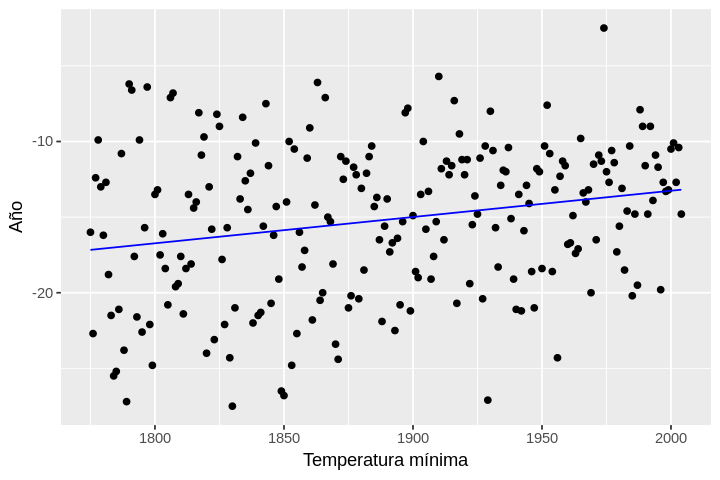

In [4]:
# calculamos la regresión lineal
model <- lm(data = weatherPraga, formula = EMNT ~ DATE)
weatherPraga$predicted <- predict(model, weatherPraga)

# mostramos el diagrama de dispersión. 
ggplot(data = weatherPraga, aes(x = DATE, y = EMNT)) + 
    geom_point() +
    geom_line(aes(y=predicted),color="blue") +
    xlab("Temperatura mínima") +
    ylab("Año")

In [5]:
model$coefficients

(Intercept)         DATE 
-48.00664189   0.01737503

Como nos indica el coeficiente, la temperatura **sube de media 0.017 grados al año**. 

¿Ha subido realmente la temperatura mínima?
* Calcula la media de la temperatura mínima (columna EMNT) del intervalo de años [1775,1794]
* Calcula la media de la temperatura mínima (columna EMNT) del intervalo de años [1985,2004]
* ¿Cual es la diferencia entre ambos? ¿Es estadísticamente significativa?
  * Nota: antes de aplicar un test estadístico hay que ver si cumple con los requisitos de ese test.

In [6]:
min_temp_s18 <- weatherPraga$EMNT[weatherPraga$DATE <= 1794]
min_temp_s20 <- weatherPraga$EMNT[weatherPraga$DATE >= 1985 & weatherPraga$DATE <= 2004]

m_s18 <- mean(min_temp_s18)
m_s20 <- mean(min_temp_s20)
paste("La media de la temperatura mínima desde el año 1775 al 1794 es:", m_s18)
paste("La media de la temperatura mínima desde el año 1985 al 2004 es:", m_s20)
paste("La diferencia de medias las dos medias es :", m_s18 - m_s20)

[1] "La media de la temperatura mínima desde el año 1775 al 1794 es: -16.935"

[1] "La media de la temperatura mínima desde el año 1985 al 2004 es: -13.04"

[1] "La diferencia de medias las dos medias es : -3.895"

Primero comprobamos si los datos corresponden a una distribucción Gaussiana usando el test de Shapiro

In [7]:
paste("Las muestras de temperatura mínima en los años 1775 al 1794 parecen seguir una gaussiana según el test de Shapiro–Wilk. pvalor:",
          shapiro.test(min_temp_s18)$p.value)
paste("Las muestras de temperatura mínima en los años 1985 al 2004 parecen seguir una gaussiana según el test de Shapiro–Wilk. pvalor:",
          shapiro.test(min_temp_s20)$p.value)

[1] "Las muestras de temperatura mínima en los años 1775 al 1794 parecen seguir una gaussiana según el test de Shapiro–Wilk. pvalor: 0.380826132704572"

[1] "Las muestras de temperatura mínima en los años 1985 al 2004 parecen seguir una gaussiana según el test de Shapiro–Wilk. pvalor: 0.0751036246207044"

Según el test de Shapiro, el rango de temperaturas del siglo XVIII es muy probable que sea una distribución Guassiana.

Para las temperaturas del rango de años del siglo XX el test de Shapiro–Wilk da un valor mas bajo, pero también parece indicar que los datos podrían responder a una distribucción normal.

Dado que son datos correlados entiendo que hay que T-test emparejado

In [8]:
t_emparejado <- t.test(min_temp_s18, min_temp_s20, paired = TRUE)
t_emparejado

paste("El p.value del test es", t_emparejado$p.value)


	Paired t-test

data:  min_temp_s18 and min_temp_s20
t = -2.4797, df = 19, p-value = 0.02269
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -7.1826393 -0.6073607
sample estimates:
mean of the differences 
                 -3.895 


[1] "El p.value del test es 0.0226901277588472"

Al ser el valor de **p.value bastante bajo** podemos decir que asumir que ambas medias no son iguales y por tanto **si es significativa la diferencia**

## Datos banco mundial

Carga los datos del banco mundial

In [9]:
databank<-read.csv("./datos/API_19_DS2_en_csv_v2.csv",skip=4)
#Borramos las X del nombre de la columna
colnames(databank)<-gsub("X","",colnames(databank))

countryData<-read.csv("./datos/Metadata_Country_API_19_DS2_en_csv_v2.csv")

# De esta forma podremos aceder a la información de paises usando su countryCode
rownames(countryData)<-countryData$Country.Code

realCountryData<-subset(countryData,IncomeGroup!="")
regionData<-subset(countryData,IncomeGroup=="")
print(paste("Tenemos un total de",nrow(realCountryData),"paises"))
print(paste("Tenemos un total de",nrow(regionData),"regiones"))
indicators<-read.csv("./datos/Metadata_Indicator_API_19_DS2_en_csv_v2.csv")
print(paste("Tenemos un total de",nrow(indicators),"indicadores"))

[1] "Tenemos un total de 217 paises"
[1] "Tenemos un total de 46 regiones"
[1] "Tenemos un total de 80 indicadores"


In [10]:
head(databank)
head(indicators)
head(realCountryData)

Country.Name,Country.Code,Indicator.Name,Indicator.Code,1960,1961,1962,1963,1964,1965,⋯,2009,2010,2011,2012,2013,2014,2015,2016,2017,
Aruba,ABW,Urban population (% of total),SP.URB.TOTL.IN.ZS,50.776000,50.761000,50.746000,5.073000e+01,5.071500e+01,5.070000e+01,⋯,4.342100e+01,4.305900e+01,4.269800e+01,4.236400e+01,4.205800e+01,4.177900e+01,4.152800e+01,4.130400e+01,NA,NA
Aruba,ABW,Urban population,SP.URB.TOTL,27526.000000,28141.000000,28532.000000,2.876100e+04,2.892400e+04,2.908200e+04,⋯,4.405200e+04,4.377800e+04,4.357500e+04,4.345600e+04,4.339800e+04,4.336500e+04,4.333100e+04,4.329600e+04,NA,NA
Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,3.117931,2.209658,1.379868,7.994038e-01,5.651398e-01,5.447726e-01,⋯,-7.305493e-01,-6.239346e-01,-4.647817e-01,-2.734659e-01,-1.335575e-01,-7.606930e-02,-7.843500e-02,-8.080622e-02,NA,NA
Aruba,ABW,"Population, total",SP.POP.TOTL,54211.000000,55438.000000,56225.000000,5.669500e+04,5.703200e+04,5.736000e+04,⋯,1.014530e+05,1.016690e+05,1.020530e+05,1.025770e+05,1.031870e+05,1.037950e+05,1.043410e+05,1.048220e+05,NA,NA
Aruba,ABW,Population growth (annual %),SP.POP.GROW,3.148037,2.238144,1.409622,8.324526e-01,5.926490e-01,5.734682e-01,⋯,9.861642e-02,2.126801e-01,3.769848e-01,5.121450e-01,5.929140e-01,5.874924e-01,5.246582e-01,4.599292e-01,NA,NA
Aruba,ABW,Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population),SI.POV.DDAY,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


INDICATOR_CODE,INDICATOR_NAME,SOURCE_NOTE,SOURCE_ORGANIZATION,X
SP.URB.TOTL.IN.ZS,Urban population (% of total),Urban population refers to people living in urban areas as defined by national statistical offices. The data are collected and smoothed by United Nations Population Division.,The United Nations Population Division's World Urbanization Prospects.,NA
SP.URB.TOTL,Urban population,Urban population refers to people living in urban areas as defined by national statistical offices. It is calculated using World Bank population estimates and urban ratios from the United Nations World Urbanization Prospects. Aggregation of urban and rural population may not add up to total population because of different country coverages.,World Bank staff estimates based on the United Nations Population Division's World Urbanization Prospects.,NA
SP.URB.GROW,Urban population growth (annual %),Urban population refers to people living in urban areas as defined by national statistical offices. It is calculated using World Bank population estimates and urban ratios from the United Nations World Urbanization Prospects.,"World Bank Staff estimates based on United Nations, World Urbanization Prospects.",NA
SP.POP.TOTL,"Population, total","Total population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship. The values shown are midyear estimates.","(1) United Nations Population Division. World Population Prospects, (2) Census reports and other statistical publications from national statistical offices, (3) Eurostat: Demographic Statistics, (4) United Nations Statistical Division. Population and Vital Statistics Report (various years), (5) U.S. Census Bureau: International Database, and (6) Secretariat of the Pacific Community: Statistics and Demography Programme.",NA
SP.POP.GROW,Population growth (annual %),"Annual population growth rate for year t is the exponential rate of growth of midyear population from year t-1 to t, expressed as a percentage . Population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship.","Derived from total population. Population source: (1) United Nations Population Division. World Population Prospects, (2) Census reports and other statistical publications from national statistical offices, (3) Eurostat: Demographic Statistics, (4) United Nations Statistical Division. Population and Vital Statistics Reprot (various years), (5) U.S. Census Bureau: International Database, and (6) Secretariat of the Pacific Community: Statistics and Demography Programme.",NA
SI.POV.DDAY,Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population),"Poverty headcount ratio at $1.90 a day is the percentage of the population living on less than $1.90 a day at 2011 international prices. As a result of revisions in PPP exchange rates, poverty rates for individual countries cannot be compared with poverty rates reported in earlier editions.","World Bank, Development Research Group. Data are based on primary household survey data obtained from government statistical agencies and World Bank country departments. Data for high-income economies are from the Luxembourg Income Study database. For more information and methodology, please see PovcalNet (http://iresearch.worldbank.org/PovcalNet/index.htm).",NA


,Country.Code,Region,IncomeGroup,SpecialNotes,TableName,X
ABW,ABW,Latin America & Caribbean,High income,SNA data for 2000-2011 are updated from official government statistics; 1994-1999 from UN databases. Base year has changed from 1995 to 2000.,Aruba,NA
AFG,AFG,South Asia,Low income,"Fiscal year end: March 20; reporting period for national accounts data is calendar year, estimated to insure consistency between national accounts and fiscal data. National accounts data are sourced from the IMF and differ from the Central Statistics Organization numbers due to exclusion of the opium economy.",Afghanistan,NA
AGO,AGO,Sub-Saharan Africa,Lower middle income,,Angola,NA
ALB,ALB,Europe & Central Asia,Upper middle income,,Albania,NA
AND,AND,Europe & Central Asia,High income,WB-3 code changed from ADO to AND to align with ISO code.,Andorra,NA
ARE,ARE,Middle East & North Africa,High income,,United Arab Emirates,NA


¿Cual fue el país que más toneladas de CO2 equivalente emitió en 1970 (Mostrar *Country.Name*)?
¿Cuanto contaminó?

Hay una dataframe con la lista de pasises en *realCountryData*
El número de toneladas de CO2 equivalente viene dado por el Indicator.Code *"EN.ATM.GHGT.KT.CE"*


In [11]:
# hay que hacer merge con la función merge o con %in%

#hacemos un merge de databank y de countryData 
df_bank_country <- merge(databank, realCountryData, by = "Country.Code", all = F)

# creamos un nuevo data frame filtrando por el Indicator.Code = EN.ATM.GHGT.KT.CE
df_CO2 <- df_bank_country[df_bank_country$Indicator.Code == "EN.ATM.GHGT.KT.CE", c("Country.Name", "Country.Code", "1970", "2012")]
#head(df_CO2)

#df_maxCO2 <- df_CO2[which(max(df_CO2[,1], na.rm = T) == df_CO2[,1]),]
head(df_CO2[,3])
df_pais_max_CO2 <- df_CO2[which.max(df_CO2[,3]),]
paste("El pais que mas a toneladas de CO2 ha emitido en 1979 fue", df_pais_max_CO2$Country.Name, "con un total de", df_pais_max_CO2[,3], "toledas de CO2")

[1]    42.3063 14306.6163 60648.6011  6960.8682         NA 32962.1894

[1] "El pais que mas a toneladas de CO2 ha emitido en 1979 fue United States con un total de 5400503.5 toledas de CO2"

¿Cuales fueron los 5 países que más toneladas de CO2 equivalente emitieron en 2012? ¿Cuantas kt emitieron?

In [16]:
# creo un data.frame ordenando por el campo 2012
df_CO2_order <- df_CO2[order(-df_CO2[,4]),]
# me quedo con las 5 primeras filas
df_5pais_max_CO2 <- df_CO2_order[1:5,]

df_5pais_max_CO2

paste("Los 5 paises que mas CO2 has emitido en 2012 son:")
df_5pais_max_CO2[, c("Country.Name")]
paste("Emitieron un total de", sum(df_5pais_max_CO2[, 4]), "toneladas de CO2")

#df_5pais_max_CO2[, c("Country.Name")]
#df_5pais_max_CO2


,Country.Name,Country.Code,1970,2012
2905,China,CHN,1873971.7,12454711
16280,United States,USA,5400503.5,6343841
7149,India,IND,746498.1,3002895
2098,Brazil,BRA,1260982.1,2989418
13246,Russian Federation,RUS,2240873.0,2803398


[1] "Los 5 paises que mas CO2 has emitido en 2012 son:"

[1] China              United States      India              Brazil            
[5] Russian Federation
264 Levels: Afghanistan Albania Algeria American Samoa Andorra ... Zimbabwe

[1] "Emitieron un total de 27594262.4849943 toneladas de CO2"

¿Cual ha sido la media del **porcentaje** de crecimiento de las emisiones de CO2 equivalente en China desde 2000 hasta 2012?

In [59]:
# obtenemos un dataframe de las emisiones de CO2 de China del año 2000 al 2012
# el Country.Code de China es CHN
df_CHN_CO2<-subset(df_bank_country, Indicator.Code== 'EN.ATM.GHGT.KT.CE' & Country.Code=='CHN')[,as.character(seq(1999,2012,1))]

# Como  tenemos cada dato en una columna, vamos a "transponer" el dataframe con la función melt
library("reshape2")
df_CHN_CO2 <- melt(df_CHN_CO2)

# para calcular el porcentaje de crecimineto vamos a crear una columna con la diferencia de un año con el anterior
df_CHN_CO2$ratio <- c(NA, df_CHN_CO2$value[2:nrow(df_CHN_CO2)] / df_CHN_CO2$value[1:nrow(df_CHN_CO2) - 1])
head(df_CHN_CO2)

myGeometricMean<-function(X,na.rm=F){
    if (na.rm==T){
        X <- na.omit(X)
    }
    m <- 1
    for (xi in X){
        m <- m*xi
    }
    m^(1/length(X))
    
    #exp(mean(log(x)))
}

# Calculamos la media geómetrica de los diferentes porcentajes
media_CO2_china <- round((myGeometricMean(df_CHN_CO2$ratio, na.rm = T) - 1) * 100, 2)
paste("La media de porcentaje de crecimiento de las emisiones ha sido:", media_CO2_china, "%")



No id variables; using all as measure variables


variable,value,ratio
1999,5079294,NA
2000,5082326,1.000597
2001,5145522,1.012434
2002,5474915,1.064016
2003,6226962,1.137362
2004,7116642,1.142875


[1] "La media de porcentaje de crecimiento de las emisiones ha sido: 7.14 %"

Compara las emisiones de CO2(kt) per cápita (clave en Indicator.Code: *EN.ATM.CO2E.PC*) de todos los paises en 1960,1990 y 2014 mediante:
* diagrama de cajas
* histograma
* curvas de densidad

In [71]:
# obtenemos un dataframe con los datos con los que vamos a trabajar
df_CO2_percapita1 <- df_bank_country[df_bank_country$Indicator.Code == "EN.ATM.CO2E.PC", c("Country.Name", "1960", "1990", "2014")]
df_CO2_percapita <- melt(df_CO2_percapita1, id="Country.Name")
colnames(df_CO2_percapita) <- c("Country", "Year", "CO2")
head(df_CO2_percapita, 10)


Country,Year,CO2
Aruba,1960,NA
Afghanistan,1960,0.0460599
Angola,1960,0.0974716
Albania,1960,1.2581949
Andorra,1960,NA
United Arab Emirates,1960,0.1187577
Argentina,1960,2.3674730
Armenia,1960,NA
American Samoa,1960,NA
Antigua and Barbuda,1960,0.6626430


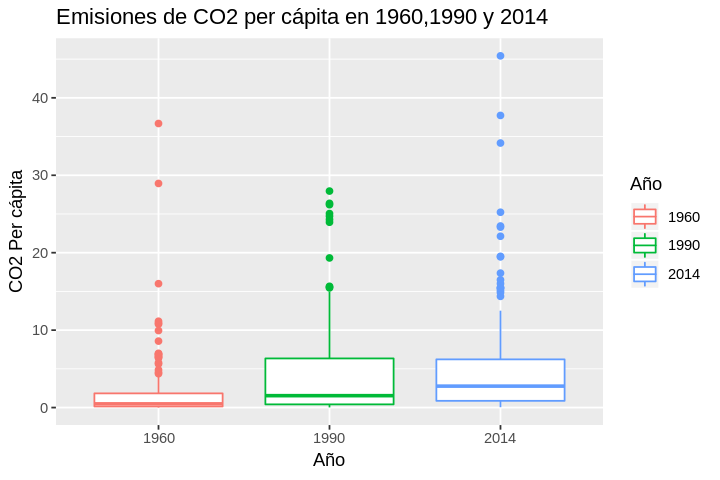

In [91]:
# mostramos el diagrama de cajas
ggplot(data = df_CO2_percapita, aes(x = Year,y = CO2, color = Year)) + 
  geom_boxplot(na.rm = T) +
  scale_color_discrete(name = "Año") + 
  xlab("Año")+
  ylab("CO2 Per cápita") +
  ggtitle("Emisiones de CO2 per cápita en 1960,1990 y 2014")

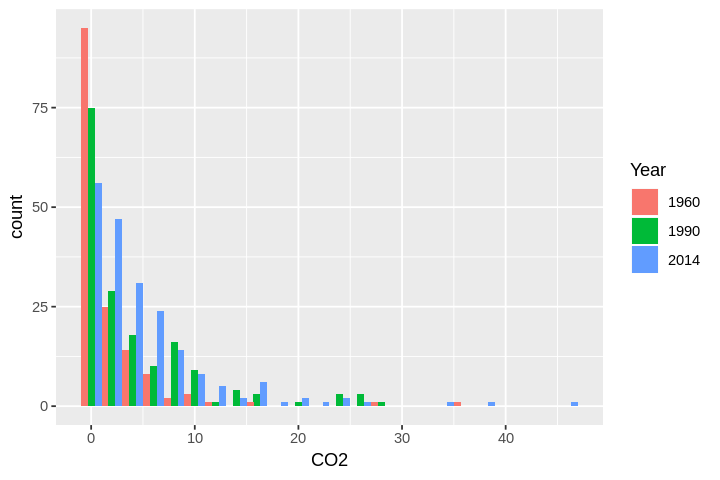

In [90]:
# mostramos el histograma
ggplot(data = df_CO2_percapita, aes(CO2, fill = Year)) + 
  scale_color_discrete(name = "Año") + 
  geom_histogram(position = "dodge", binwidth = 2, na.rm = T)

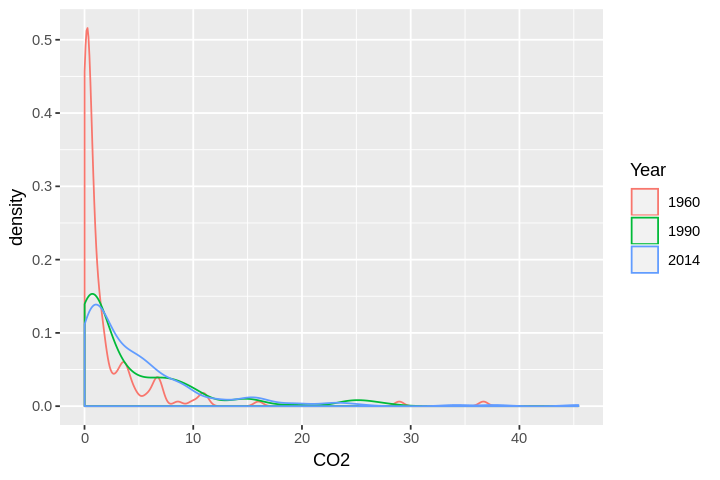

In [89]:
# mostramos las curvas de densidad
ggplot(data = df_CO2_percapita, aes(CO2, color = Year)) + 
  geom_density(na.rm = T)  

Utilizando ggplot: Compara en una gráfica las emisiones totales de CO2 (clave en Indicator.Code: EN.ATM.CO2E.KT) en función del año de las siguientes regiones:
* Mundo entero: WLD
* Unión europea: EUU
* Africa subsahariana: SSA
* Norteamérica: NAC
* Este de Asia y pacífico: TEA

Ayuda: Tendrás que usar la función *melt()* para transformar los años, cada año en una columna, en un data.frame donde cada uno esté en una fila.

In [96]:
df_CO2_tot <- subset(databank, Indicator.Code== 'EN.ATM.CO2E.KT' & 
                     Country.Code %in% c("WLD","EUU","SSA","NAC","TEA"),
                    c(1,5:ncol(databank)))
df_CO2_tot <- melt(df_CO2_tot, id = "Country.Name")
colnames(df_CO2_tot) <- c("Country", "Year", "CO2")
head(df_CO2_tot)

Country,Year,CO2
European Union,1960,2359594.9
North America,1960,3083749.0
Sub-Saharan Africa (excluding high income),1960,126081.5
East Asia & Pacific (IDA & IBRD countries),1960,840235.7
World,1960,9396705.8
European Union,1961,2445945.7


Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning mess

“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with

“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with

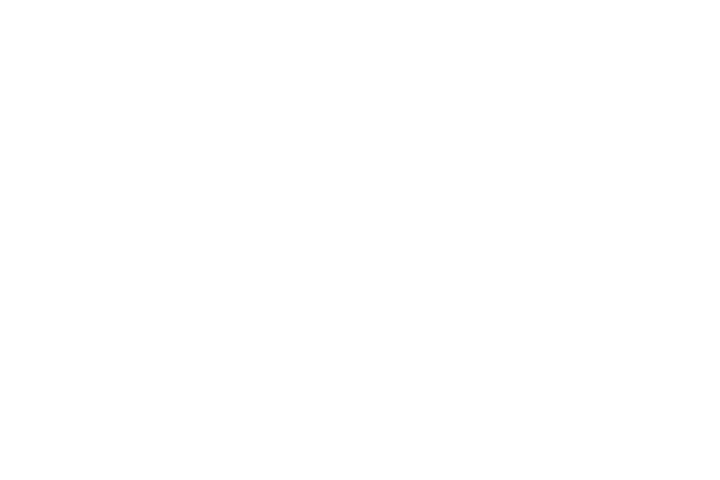

Suponiendo que la tendencia se mantiene, es decir, que no se aplica ninguna política a nivel global de reducción de emisiones de CO2, ¿cual sería el total de emisiones de CO2 en todo el mundo en el año 2020?

Para calcularlo utiliza tres modelos lineales:
* Regresión lineal con polinomio grado 1
* Regresión lineal polinomio grado 3
* Regresión lineal polinomio grado 10

Represénta en una gráfica el valor real y el calculado por cada uno de los 3 modelos.

## Nivel de CO2

En esta parte vamos a trabajar con el nivel medio de CO2 medido por el NOAA en Manuna Loa (Hawai) desde 1968.

In [13]:
co2ppm<-read.csv("./datos/co2_mm_mlo.txt",skip=73,sep="",header = F, 
                 col.names= c("year","month","date","average","interpolated","trend","days"))

Representa el diagrama de dispersión entre:
* CO2 medido en la atmósfera (co2ppm\$interpolated)
* CO2 emitido por todos los países (databank con Indicator.Code=="EN.ATM.CO2E.KT" y Country.Code=="WLD"?

¿Cual es su correlación?


Nota: 

* Los valores en co2ppm vienen en meses, habrá que agregarlos, calcular la media anual a partir de los meses para así poder hacer la correlación con databank.
* Los valores en databank vienen en columnas, habrá que pasarlos a filas utilizando la función *melt*.

In [14]:
# Agregamos y calculamos el nivel de CO2 medio anual
yearlyco2ppm<-aggregate(interpolated ~ year, data = co2ppm, mean)


Calcular la matriz de correlación de las siguientes variables:
* Cantidad de CO2 en la atmósfera
* Emisiones totales CO2 en la atmósfera
* Temperatura mínima en praga (columna EMNT).